In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
import pandas_datareader.data as web
import pickle 
import requests
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors

C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\f

In [2]:
image_path = 'D:/kenneth/agent/images/'
ticker = '^GSPC'
start=('2019-01-01')
end=('2019-12-31')
# df=web.DataReader(ticker,'yahoo',start,end)
# df.to_csv(ticker+'.csv')
df = pd.read_csv('D:/kenneth/agent/'+ticker+'.csv', index_col=0, parse_dates=True)

#  Agents

* Turtle Trading agent
* Moving Average agent
* Signal Rolling agent
* Policy Gradient agent
* Q-learning agent
* Evolution Strategy agent
* Double Q-learning agent
* Recurrent Q-learning agent
* Double Recurrent Q-learning agent
* Duel Q-learning agent
* Double Duel Q-learning agent
* Duel Recurrent Q-learning agent
* Double Duel Recurrent Q-learning agent
* Actor-critic agent
* Actor-critic Duel agent
* Actor-critic Recurrent agent
* Actor-critic Duel Recurrent agent
* Curiosity Q-learning agent
* Recurrent Curiosity Q-learning agent
* Duel Curiosity Q-learning agent
* Neuro-evolution agent
* Neuro-evolution with Novelty search agent
* ABCD strategy agent
* Deep Evolution Strategy

## Neuro-evolution with Novelty search agent

In [3]:
name = 'Neuro-evolution with Novelty search agent'

close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1

novelty_search_threshold = 6
novelty_log_maxlen = 1000
backlog_maxsize = 500
novelty_log_add_amount = 3

In [4]:
class neuralnetwork:
    def __init__(self, id_, hidden_size = 128):
        self.W1 = np.random.randn(window_size, hidden_size) / np.sqrt(window_size)
        self.W2 = np.random.randn(hidden_size, 3) / np.sqrt(hidden_size)
        self.fitness = 0
        self.last_features = None
        self.id = id_

def relu(X):
    return np.maximum(X, 0)
    
def softmax(X):
    e_x = np.exp(X - np.max(X, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def feed_forward(X, nets):
    a1 = np.dot(X, nets.W1)
    z1 = relu(a1)
    a2 = np.dot(z1, nets.W2)
    return softmax(a2)

In [5]:
class NeuroEvolution:
    def __init__(self, population_size, mutation_rate, model_generator,
                state_size, window_size, trend, skip, initial_money):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.model_generator = model_generator
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.generation_backlog = []
        self.novel_backlog = []
        self.novel_pop = []
        
    def _initialize_population(self):
        self.population = []
        for i in range(self.population_size):
            self.population.append(self.model_generator(i))
    
    def _memorize(self, q, i, limit):
        q.append(i)
        if len(q) > limit:
            q.pop()
    
    def mutate(self, individual, scale=1.0):
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W1.shape)
        individual.W1 += np.random.normal(loc=0, scale=scale, size=individual.W1.shape) * mutation_mask
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W2.shape)
        individual.W2 += np.random.normal(loc=0, scale=scale, size=individual.W2.shape) * mutation_mask
        return individual
    
    def inherit_weights(self, parent, child):
        child.W1 = parent.W1.copy()
        child.W2 = parent.W2.copy()
        return child
    
    def crossover(self, parent1, parent2):
        child1 = self.model_generator((parent1.id+1)*10)
        child1 = self.inherit_weights(parent1, child1)
        child2 = self.model_generator((parent2.id+1)*10)
        child2 = self.inherit_weights(parent2, child2)
        # first W
        n_neurons = child1.W1.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W1[:, cutoff:] = parent2.W1[:, cutoff:].copy()
        child2.W1[:, cutoff:] = parent1.W1[:, cutoff:].copy()
        # second W
        n_neurons = child1.W2.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W2[:, cutoff:] = parent2.W2[:, cutoff:].copy()
        child2.W2[:, cutoff:] = parent1.W2[:, cutoff:].copy()
        return child1, child2
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def act(self, p, state):
        logits = feed_forward(state, p)
        return np.argmax(logits, 1)[0]
    
    def buy(self, individual):
        initial_money = self.initial_money
        starting_money = initial_money
        state = self.get_state(0)
        inventory = []
        states_sell = []
        states_buy = []
        
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(individual, state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((self.trend[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, self.trend[t], invest, initial_money)
                )
            state = next_state
        
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    
    def calculate_fitness(self):
        for i in range(self.population_size):
            initial_money = self.initial_money
            starting_money = initial_money
            state = self.get_state(0)
            inventory = []
            
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(self.population[i], state)
                next_state = self.get_state(t + 1)
            
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    starting_money += self.trend[t]

                state = next_state
            invest = ((starting_money - initial_money) / initial_money) * 100
            self.population[i].fitness = invest
            self.population[i].last_features = self.population[i].W2.flatten()
    
    def evaluate(self, individual, backlog, pop, k = 4):
        score = 0
        if len(backlog):
            x = np.array(backlog)
            nn = NearestNeighbors(n_neighbors = k, metric = 'euclidean').fit(np.array(backlog))
            d, _ = nn.kneighbors([individual])
            score += np.mean(d)
        
        if len(pop):
            nn = NearestNeighbors(n_neighbors = k, metric = 'euclidean').fit(np.array(pop))
            d, _ = nn.kneighbors([individual])
            score += np.mean(d)
        
        return score
    
    def evolve(self, generations=20, checkpoint= 5):
        self._initialize_population()
        n_winners = int(self.population_size * 0.4)
        n_parents = self.population_size - n_winners
        for epoch in range(generations):
            self.calculate_fitness()
            scores = [self.evaluate(p.last_features, self.novel_backlog, self.novel_pop) for p in self.population]
            sort_fitness = np.argsort(scores)[::-1]
            self.population = [self.population[i] for i in sort_fitness]
            fittest_individual = self.population[0]
            if (epoch+1) % checkpoint == 0:
                print('epoch %d, fittest individual %d with accuracy %f'%(epoch+1, sort_fitness[0], 
                                                                          fittest_individual.fitness))
            next_population = [self.population[i] for i in range(n_winners)]
            total_fitness = np.sum([np.abs(i.fitness) for i in self.population])
            parent_probabilities = [np.abs(i.fitness / total_fitness) for i in self.population]
            parents = np.random.choice(self.population, size=n_parents, p=parent_probabilities, replace=False)
            
            for p in next_population:
                if p.last_features is not None:
                    self._memorize(self.novel_pop, p.last_features, backlog_maxsize)
                    if np.random.randint(0,10) < novelty_search_threshold:
                        self._memorize(self.novel_backlog, p.last_features, novelty_log_maxlen)
                        
            for i in np.arange(0, len(parents), 2):
                child1, child2 = self.crossover(parents[i], parents[i+1])
                next_population += [self.mutate(child1), self.mutate(child2)]
            self.population = next_population
            
            if np.random.randint(0,10) < novelty_search_threshold:
                pop_sorted = sorted(self.population, key=lambda p: p.fitness, reverse=True)
                self.generation_backlog.append(pop_sorted[0])
                print('novel add fittest, score: %f, backlog size: %d'%(pop_sorted[0].fitness, 
                                                                        len(self.generation_backlog)))
                generation_backlog_temp = self.generation_backlog
                if len(self.generation_backlog) > backlog_maxsize:
                    generation_backlog_temp = random.sample(generation_backlog, backlog_maxsize)
                for p in generation_backlog_temp:
                    if p.last_features is not None:
                        self._memorize(self.novel_backlog, p.last_features, novelty_log_maxlen)
                        
        return fittest_individual

In [6]:
population_size = 100
generations = 100
mutation_rate = 0.1
neural_evolve = NeuroEvolution(population_size, mutation_rate, neuralnetwork,
                              window_size, window_size, close, skip, initial_money)

In [7]:
fittest_nets = neural_evolve.evolve(500)

novel add fittest, score: 6.504795, backlog size: 1
novel add fittest, score: 9.797405, backlog size: 2
epoch 5, fittest individual 61 with accuracy -76.896401
novel add fittest, score: 0.605801, backlog size: 3
novel add fittest, score: 3.266404, backlog size: 4
novel add fittest, score: 8.170889, backlog size: 5
novel add fittest, score: 8.433196, backlog size: 6
epoch 10, fittest individual 93 with accuracy -75.542397
novel add fittest, score: 2.873000, backlog size: 7
novel add fittest, score: 7.999399, backlog size: 8
epoch 15, fittest individual 40 with accuracy -78.000701
novel add fittest, score: 0.000000, backlog size: 9
novel add fittest, score: 8.932903, backlog size: 10
novel add fittest, score: 0.000000, backlog size: 11
epoch 20, fittest individual 51 with accuracy -76.425498
novel add fittest, score: 0.000000, backlog size: 12
novel add fittest, score: 0.000000, backlog size: 13
novel add fittest, score: 0.000000, backlog size: 14
epoch 25, fittest individual 73 with acc

novel add fittest, score: 0.000000, backlog size: 116
novel add fittest, score: 0.000000, backlog size: 117
novel add fittest, score: 0.000000, backlog size: 118
epoch 195, fittest individual 87 with accuracy -80.437900
novel add fittest, score: 0.000000, backlog size: 119
novel add fittest, score: 0.000000, backlog size: 120
novel add fittest, score: 0.000000, backlog size: 121
novel add fittest, score: 0.000000, backlog size: 122
epoch 200, fittest individual 60 with accuracy -81.033794
novel add fittest, score: 0.000000, backlog size: 123
epoch 205, fittest individual 87 with accuracy -77.878992
novel add fittest, score: 0.000000, backlog size: 124
novel add fittest, score: 0.000000, backlog size: 125
novel add fittest, score: 0.000000, backlog size: 126
epoch 210, fittest individual 40 with accuracy -77.486692
novel add fittest, score: 0.000000, backlog size: 127
epoch 215, fittest individual 85 with accuracy -79.127097
novel add fittest, score: 0.000000, backlog size: 128
novel ad

novel add fittest, score: 0.000000, backlog size: 226
novel add fittest, score: 0.000000, backlog size: 227
novel add fittest, score: 0.000000, backlog size: 228
epoch 390, fittest individual 95 with accuracy -80.320891
novel add fittest, score: 0.000000, backlog size: 229
novel add fittest, score: 0.000000, backlog size: 230
novel add fittest, score: 0.000000, backlog size: 231
novel add fittest, score: 0.000000, backlog size: 232
epoch 395, fittest individual 0 with accuracy -77.199094
novel add fittest, score: 0.000000, backlog size: 233
novel add fittest, score: 0.000000, backlog size: 234
novel add fittest, score: 0.000000, backlog size: 235
novel add fittest, score: 0.000000, backlog size: 236
epoch 400, fittest individual 0 with accuracy -80.929695
novel add fittest, score: 0.000000, backlog size: 237
novel add fittest, score: 0.000000, backlog size: 238
novel add fittest, score: 0.000000, backlog size: 239
novel add fittest, score: 0.000000, backlog size: 240
epoch 405, fittest

In [8]:
states_buy, states_sell, total_gains, invest = neural_evolve.buy(fittest_nets)

day 3: buy 1 unit at price 2549.689941, total balance 7450.310059
day 4, sell 1 unit at price 2574.409912, investment 0.969529 %, total balance 10024.719971,
day 5: buy 1 unit at price 2584.959961, total balance 7439.760010
day 6: buy 1 unit at price 2596.639893, total balance 4843.120117
day 8, sell 1 unit at price 2582.610107, investment -0.090905 %, total balance 7425.730225,
day 9: buy 1 unit at price 2610.300049, total balance 4815.430176
day 10, sell 1 unit at price 2616.100098, investment 0.749438 %, total balance 7431.530273,
day 11: buy 1 unit at price 2635.959961, total balance 4795.570312
day 12: buy 1 unit at price 2670.709961, total balance 2124.860352
day 13: buy 1 unit at price 2632.899902, total balance -508.039551
day 15: buy 1 unit at price 2642.330078, total balance -3150.369629
day 16, sell 1 unit at price 2664.760010, investment 2.086349 %, total balance -485.609619,
day 17, sell 1 unit at price 2643.850098, investment 0.299327 %, total balance 2158.240479,
day 20:

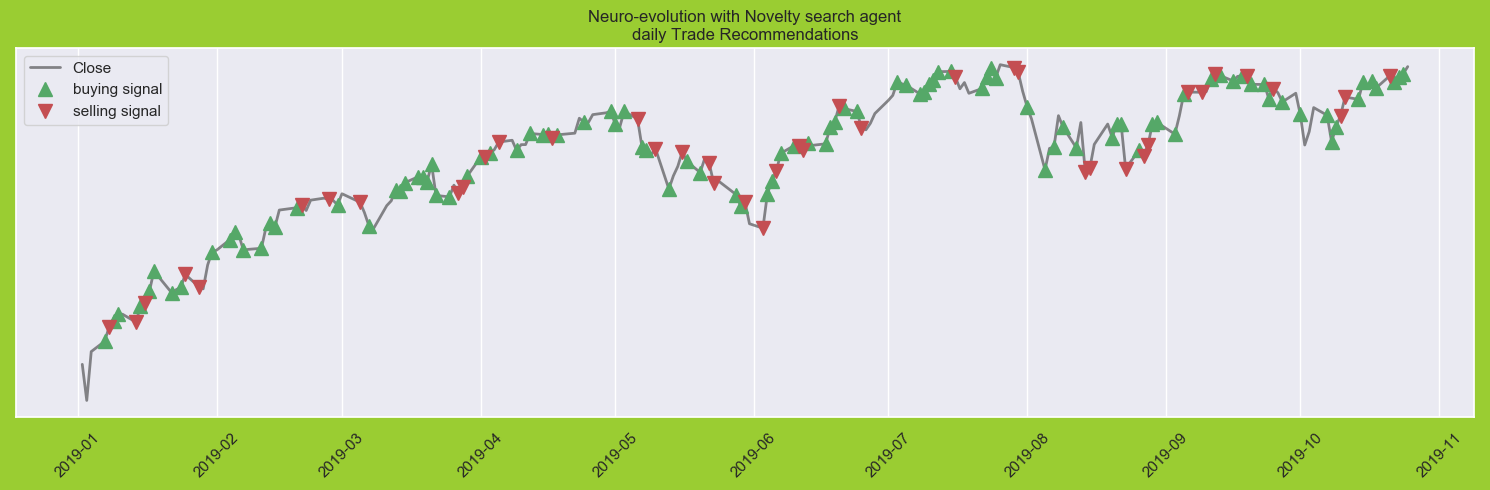

In [9]:
close = df['Close']
fig = plt.figure(figsize = (15,5), facecolor='yellowgreen', dpi=100)
plt.plot(close, color='k', lw=2., alpha=0.5)
plt.plot(close, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
plt.title(name+'\n'+'daily Trade Recommendations')
plt.legend()
plt.xticks(rotation=45)
plt.gca().axes.get_yaxis().set_visible(False)
fig.tight_layout()
plt.savefig('images/'+ticker+name+'.png', facecolor='yellowgreen', dpi=100)
plt.show()

In [10]:
display_days = 30
total_days= df.shape[0]
display_from = total_days-display_days

In [11]:
new_buy = []
for i in(states_buy):
    if i > display_from:
        adj = i- display_from
        new_buy.append(adj)
new_buy

[2, 4, 5, 6, 9, 11, 15, 16, 17, 20, 21, 23, 24, 26, 27, 28]

In [12]:
new_sell = []
for i in(states_sell):
    if i > display_from:
        adj = i- display_from
        new_sell.append(adj)
new_sell

[3, 7, 18, 19, 25]

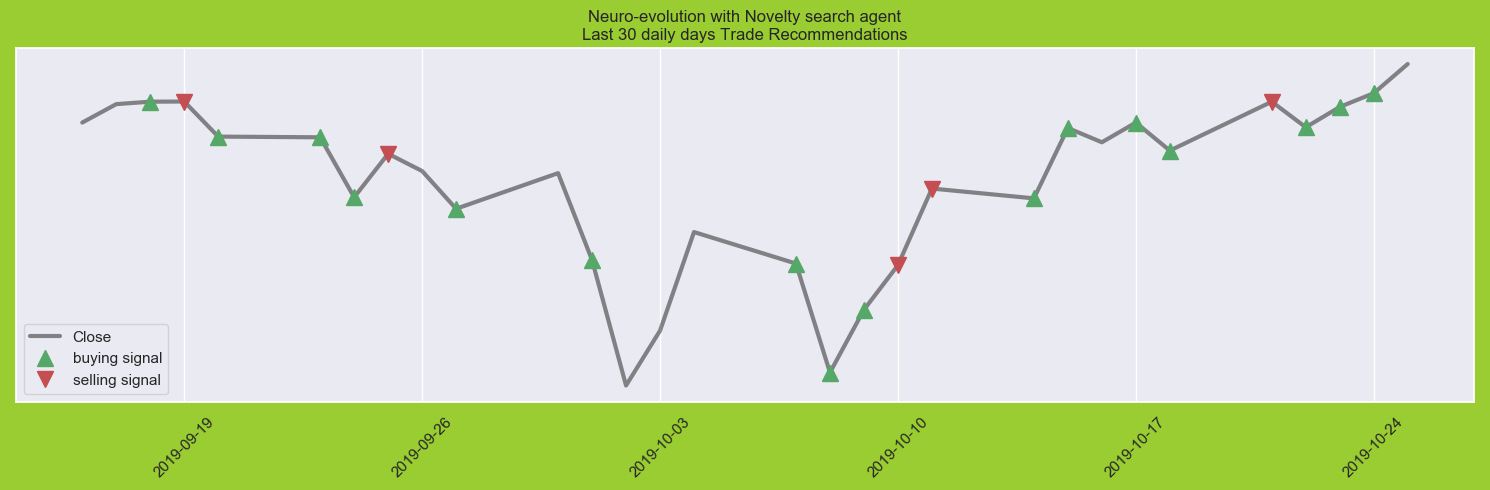

In [13]:
close = df['Close'][-display_days:]
fig = plt.figure(figsize = (15,5), facecolor='yellowgreen', dpi=100)
plt.plot(close, color='k', lw=3., alpha=0.5)
plt.plot(close, '^', markersize=12, color='g',alpha=1.0,label = 'buying signal', markevery = new_buy)
plt.plot(close, 'v', markersize=12, color='r',alpha=1.0, label = 'selling signal', markevery = new_sell)
plt.title(name+'\n'+'Last '+str(display_days)+' daily days Trade Recommendations')
plt.legend()
plt.xticks(rotation=45)
plt.gca().axes.get_yaxis().set_visible(False)
fig.tight_layout()
#plt.savefig('images/'+ticker+name+'.png', facecolor='yellowgreen', dpi=100)
plt.show()